Aquí lo que vamos a presentar, es una visualización de los vectores de caraterisiticas que estamos generan con la red, donde mostramos el conjunto de entrenamiento como una muestra de las regiones y el conjunto de evaluacion, donde esta clasificando estas imagenes en que region.

- El objetivo de esta visualizacion es, dar una idea de que tanto cambian las representaciones de nuestro conjunto.


In [43]:
from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [44]:
device = "cuda"

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
        ) 

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [46]:
fase_0 = torch.load("Fase_0_stack.pth")
del fase_0["linear_relu_stack.4.weight"]
del fase_0["linear_relu_stack.4.bias"]

In [47]:
model = NeuralNetwork().to(device)
model.load_state_dict(fase_0)


<All keys matched successfully>

In [48]:
data_dir = "../data" 
# Conjunto de datos MNIST
train_data = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
eval_data = datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Calcular media y desviación estándar del conjunto de entrenamiento
train_mean = torch.mean(train_data.data.float()) / 255.0
train_std = torch.std(train_data.data.float()) / 255.0

# Imprimir la media y la desviación estándar
print(f"Media del conjunto de entrenamiento: {train_mean:.4f}")
print(f"Desviación estándar del conjunto de entrenamiento: {train_std:.4f}")

# Función de normalización por lotes
def batch_normalize_images(input_images, mean, std):
    return (input_images - mean) / std

# Aplicar la normalización al conjunto de entrenamiento
train_data.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: batch_normalize_images(x, mean=train_mean, std=train_std))
])

# Aplicar la normalización al conjunto de evaluación
eval_data.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: batch_normalize_images(x, mean=train_mean, std=train_std))
])

# Cargar conjuntos de datos normalizados
train_dataloader = DataLoader(train_data, 32, shuffle=True)
eval_dataloader = DataLoader(eval_data, batch_size=10000, shuffle=True)

print("Se cargaron los datos correctamente")

Media del conjunto de entrenamiento: 0.1307
Desviación estándar del conjunto de entrenamiento: 0.3081
Se cargaron los datos correctamente


In [51]:
def extractor(dataloader, model):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Obtener las características (vectores de características) del modelo
            features = model(X)
            all_features.append(features.cpu())
            all_labels.append(y.cpu())

    # Concatenar todas las características y etiquetas
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_features, all_labels


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.011s...
[t-SNE] Computed neighbors for 60000 samples in 48.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

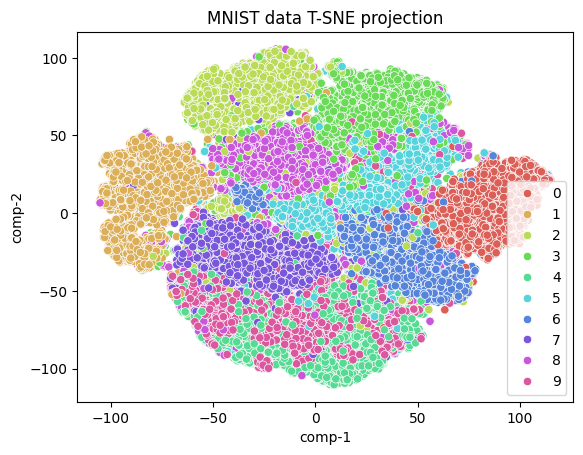

In [52]:

features, labels = extractor(train_dataloader, model)

# Usar t-SNE para reducir las dimensiones a 2
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features)

# Crear un DataFrame para la visualización con seaborn
df = pd.DataFrame()
df["y"] = labels.tolist()
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

# Visualizar con seaborn
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection")


In [ ]:
batch_size = 32
# Conjunto de entrenamiento
train_indices_0_to_4 = [i for i in range(len(train_data)) if train_data.targets[i] < 5]
train_indices_5_to_9 = [i for i in range(len(train_data)) if train_data.targets[i] >= 5]

train_0_to_4 = torch.utils.data.Subset(train_data, train_indices_0_to_4)
train_5_to_9 = torch.utils.data.Subset(train_data, train_indices_5_to_9)

# Conjunto de evaluación
eval_indices_0_to_4 = [i for i in range(len(eval_data)) if eval_data.targets[i] < 5]
eval_indices_5_to_9 = [i for i in range(len(eval_data)) if eval_data.targets[i] >= 5]

eval_0_to_4 = torch.utils.data.Subset(eval_data, eval_indices_0_to_4)
eval_5_to_9 = torch.utils.data.Subset(eval_data, eval_indices_5_to_9)
 
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
train_0_to_4_dataloader = DataLoader(train_0_to_4, batch_size, shuffle=True)
train_5_to_9_dataloader = DataLoader(train_5_to_9, batch_size, shuffle=True)